In [1]:
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)

employment = pd.read_csv("employment.csv")

In [2]:
employment.head()

,ref_area.label,source.label,indicator.label,sex.label,classif1.label,time,obs_value,obs_status.label,note_classif.label,note_indicator.label,note_source.label
0,Aruba,LFS - Labour Force Survey,Employment by sex and economic activity (thous...,Sex: Total,Economic activity (Broad sector): Total,2011,47.915,NaN,NaN,NaN,NaN
1,Aruba,LFS - Labour Force Survey,Employment by sex and economic activity (thous...,Sex: Total,Economic activity (Broad sector): Agriculture,2011,0.286,NaN,NaN,NaN,NaN
2,Aruba,LFS - Labour Force Survey,Employment by sex and economic activity (thous...,Sex: Total,Economic activity (Broad sector): Non-agriculture,2011,47.629,NaN,NaN,NaN,NaN
3,Aruba,LFS - Labour Force Survey,Employment by sex and economic activity (thous...,Sex: Total,Economic activity (Broad sector): Industry,2011,6.728,NaN,NaN,NaN,NaN
4,Aruba,LFS - Labour Force Survey,Employment by sex and economic activity (thous...,Sex: Total,Economic activity (Broad sector): Services,2011,40.763,NaN,NaN,NaN,NaN


### World AI Automation High Risk Count Estimation Map

In [3]:
employment_isic_total = employment[
    employment["classif1.label"].str.contains("ISIC")
    & employment["classif1.label"].str.contains("Total")
]

In [4]:
riskjob = pd.read_csv("JobRisk.csv")

In [5]:
riskjob.head()

,Country,Share of Jobs at Highest Risk of Automation
0,Luxembourg,17.7
1,United Kingdom of Great Britain and Northern I...,19.0
2,Sweden,20.1
3,Netherlands,20.9
4,Norway,21.0


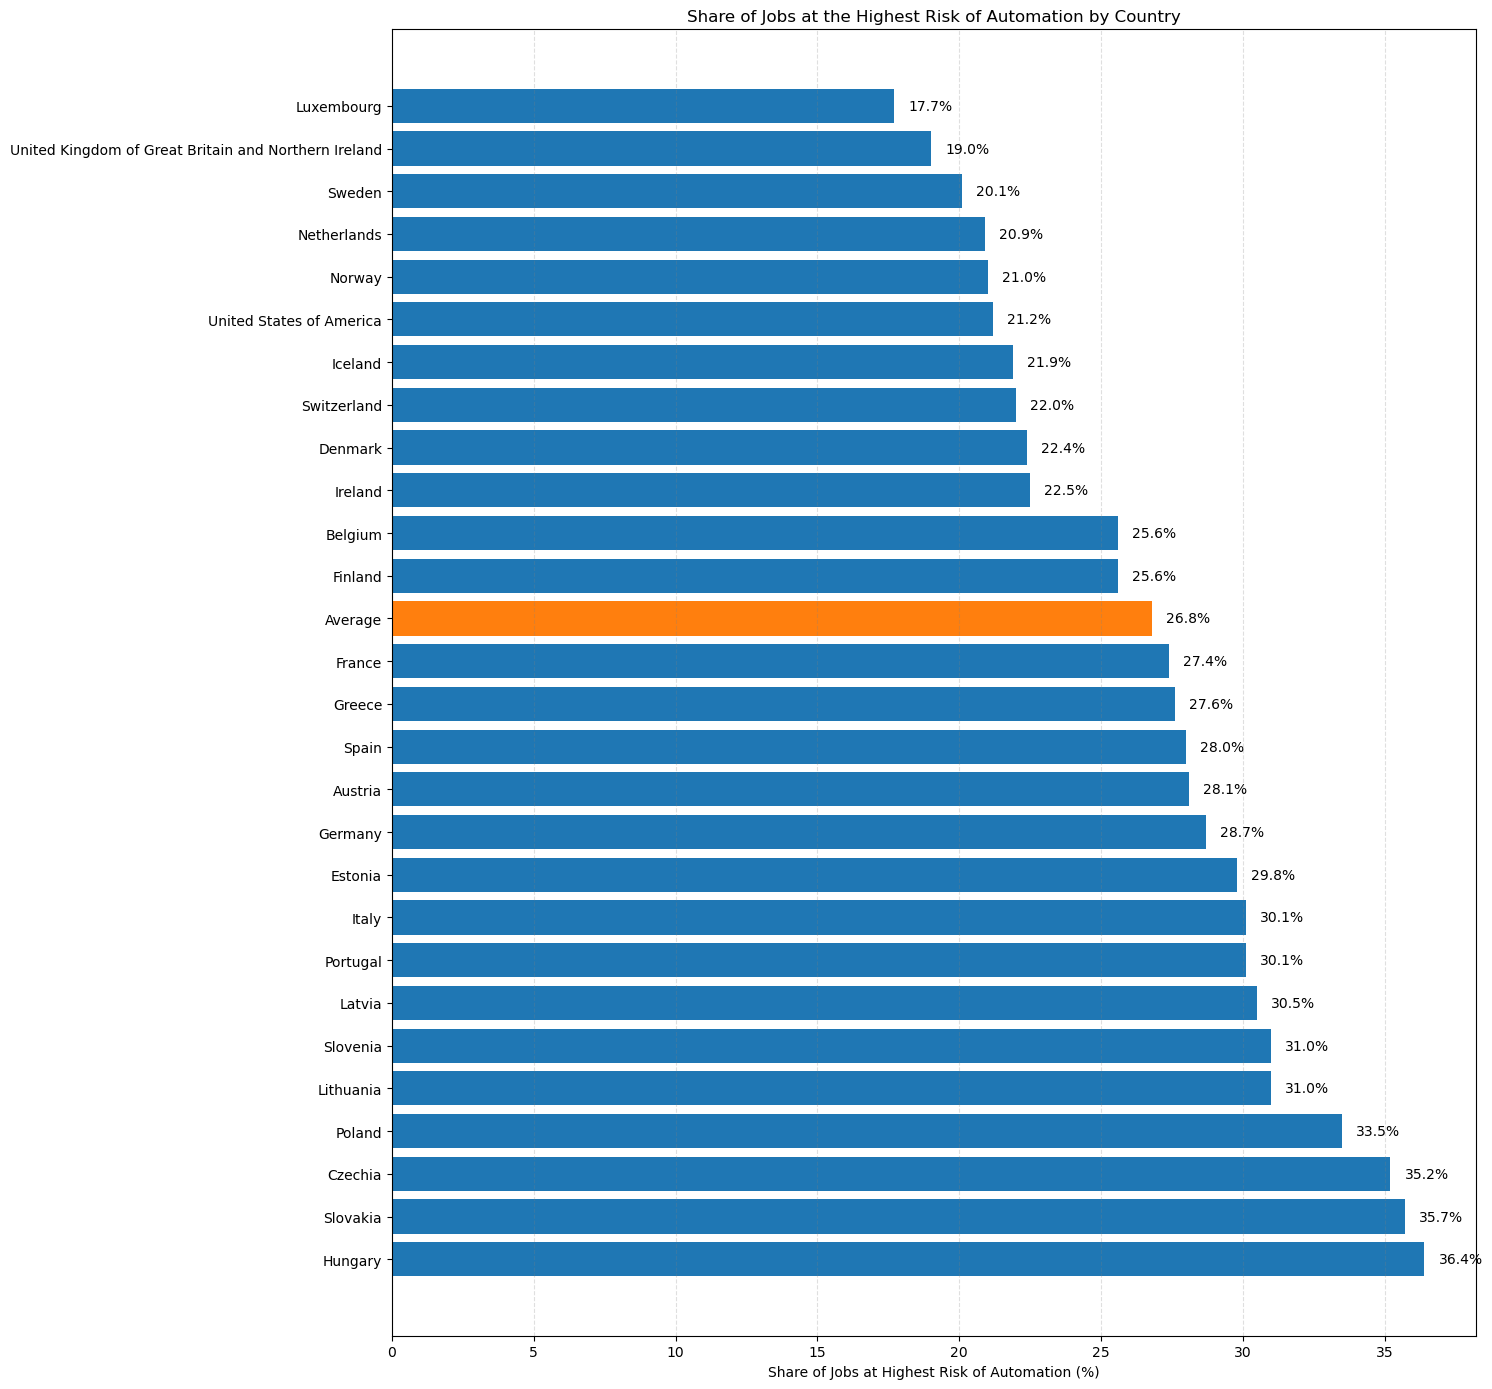

In [9]:
import seaborn as sns
import seaborn.objects as so

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import matplotlib.pyplot as plt

# Plot
fig, ax = plt.subplots(figsize=(15, 14))

# Set color scheme
colors = [
    "#1f77b4" if country != "Average" else "#ff7f0e" for country in riskjob["Country"]
]

bars = ax.barh(
    riskjob["Country"],
    riskjob["Share of Jobs at Highest Risk of Automation"],
    color=colors,
)

# Labels and title
ax.set_xlabel("Share of Jobs at Highest Risk of Automation (%)")
ax.set_title("Share of Jobs at the Highest Risk of Automation by Country")

# Grid lines
ax.xaxis.grid(True, linestyle="--", which="major", color="grey", alpha=0.25)

# Invert y-axis to have the highest value on top
ax.invert_yaxis()

# Add data labels
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.5
    ax.text(
        label_x_pos,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f}%",
        va="center",
        ha="left",
        fontsize=10,
    )

# Improve layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
merged_countries = employment_isic_total.merge(
    riskjob, left_on="ref_area.label", right_on="Country"
)

In [8]:
merged_countries["time"] = merged_countries["time"].astype(int)

In [9]:
max_time = merged_countries.groupby(["ref_area.label", "sex.label"]).apply(
    lambda x: x.sort_values(by="time", ascending=False).head(1),
    include_groups=False,  # Added argument to silence the warning
)
max_time = max_time.reset_index(drop=False)

In [10]:
max_time["affected"] = (
    max_time["obs_value"]
    * 1000
    * max_time["Share of Jobs at Highest Risk of Automation"]
    / 100
).astype(int)

In [11]:
max_time_map = max_time[["ref_area.label", "sex.label", "affected"]]

In [12]:
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html
from dash.dependencies import Input, Output

# Create the Dash app
app = Dash(__name__)

app.layout = html.Div(
    [
        html.H1("Affected Population by Sex and Country"),
        dcc.Dropdown(
            id="sex-dropdown",
            options=[
                {"label": sex, "value": sex}
                for sex in max_time_map["sex.label"].unique()
            ],
            value="Sex: Total",
        ),
        dcc.Graph(id="map-graph"),
    ]
)


@app.callback(Output("map-graph", "figure"), [Input("sex-dropdown", "value")])
def update_figure(selected_sex):
    filtered_df = max_time_map[max_time_map["sex.label"] == selected_sex]

    fig = px.choropleth(
        filtered_df,
        locations="ref_area.label",
        locationmode="country names",
        color="affected",
        hover_name="ref_area.label",
        color_continuous_scale=px.colors.sequential.Plasma,
        title=f"Jobs at Highest Risk of AI Automation by {selected_sex}, OECD Data",
    )

    fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
    return fig


if __name__ == "__main__":
    app.run_server(debug=True, port=8052)

### World All Industry Employment

In [13]:
employment_isic_total["time"] = employment_isic_total["time"].astype(int)

In [14]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html
from dash.dependencies import Input, Output

# Create the Dash app
app = Dash(__name__)

app.layout = html.Div(
    [
        html.H1("Employment by Sex and Economic Activity"),
        dcc.Dropdown(
            id="sex-dropdown",
            options=[
                {"label": sex, "value": sex}
                for sex in employment_isic_total["sex.label"].unique()
            ],
            value="Total",
        ),
        dcc.Slider(
            id="year-slider",
            min=employment_isic_total["time"].min(),
            max=employment_isic_total["time"].max(),
            value=employment_isic_total["time"].min(),
            marks={
                str(year): {"label": str(year), "style": {"font-size": "9px"}}
                for year in employment_isic_total["time"].unique()
            },
            step=None,
        ),
        dcc.Graph(id="map-graph"),
    ]
)


@app.callback(
    Output("map-graph", "figure"),
    [Input("sex-dropdown", "value"), Input("year-slider", "value")],
)
def update_figure(selected_sex, selected_year):
    filtered_df = employment_isic_total[
        (employment_isic_total["sex.label"] == selected_sex)
        & (employment_isic_total["time"] == selected_year)
    ]

    fig = px.choropleth(
        filtered_df,
        locations="ref_area.label",
        locationmode="country names",
        color="obs_value",
        hover_name="ref_area.label",
        color_continuous_scale=px.colors.sequential.Plasma,
        title=f"Employment by sex and economic activity ({selected_sex}) in {selected_year}",
    )

    fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
    return fig


if __name__ == "__main__":
    app.run_server(debug=True, port=8051)

### United State

In [15]:
# United States of America
us = employment[employment["ref_area.label"] == "United States of America"]

In [16]:
# classif1.label contain isic
us_isic = us[us["classif1.label"].str.contains("ISIC")]

In [17]:
risk = pd.read_csv("GSIndustryRisk.csv")

In [18]:
risk["average"] = risk.groupby("Mapping")["Percentage"].transform("mean")

In [19]:
risk_subset = risk[["Mapping", "average"]].drop_duplicates()

In [20]:
merged = us_isic.merge(risk_subset, left_on="classif1.label", right_on="Mapping")

In [21]:
merged_subset = merged[
    ["ref_area.label", "sex.label", "classif1.label", "time", "obs_value", "average"]
]

In [22]:
merged_subset_2023 = merged_subset[merged_subset["time"] == 2023]

In [23]:
merged_subset_2023["affected"] = (
    merged_subset_2023["obs_value"] * merged_subset_2023["average"] / 100 * 1000
).astype(int)

#### United State AI Affected Industry Count Estimation -- US Map only

In [24]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# Get unique values for sex.label and classif1.label
sex_options = merged_subset_2023["sex.label"].unique()
class_options = merged_subset_2023["classif1.label"].unique()

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div(
    [
        dcc.Graph(id="map-graph"),
        html.Label("Select Sex:"),
        dcc.Dropdown(
            id="sex-dropdown",
            options=[{"label": sex, "value": sex} for sex in sex_options],
            value="Sex: Total",  # Default value
        ),
        html.Label("Select Class:"),
        dcc.Dropdown(
            id="class-dropdown",
            options=[
                {"label": class_label, "value": class_label}
                for class_label in class_options
            ],
            value="Class A",  # Default value
        ),
    ]
)


# Define callback to update the map based on dropdown selection
@app.callback(
    Output("map-graph", "figure"),
    [Input("sex-dropdown", "value"), Input("class-dropdown", "value")],
)
def update_map(sex, class_label):
    # Filter DataFrame based on selected sex and class
    filtered_df = merged_subset_2023[
        (merged_subset_2023["sex.label"] == sex)
        & (merged_subset_2023["classif1.label"] == class_label)
    ]

    # Create choropleth map
    fig = px.choropleth(
        filtered_df,
        locations="ref_area.label",
        locationmode="country names",
        scope="usa",
        color="affected",
        hover_data=["classif1.label", "sex.label"],
        labels={"affected": "Affected"},
        title=f"Affected by Class ({sex}, {class_label})",
        color_continuous_scale="Viridis",
    )

    return fig


# Run the app
if __name__ == "__main__":
    app.run_server(debug=True, port=8055)

#### United State AI Affected Industry Count Estimation -- World Map version

In [25]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# Get unique values for sex.label and classif1.label
sex_options = merged_subset_2023["sex.label"].unique()
class_options = merged_subset_2023["classif1.label"].unique()

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div(
    [
        dcc.Graph(id="map-graph"),
        html.Label("Select Sex:"),
        dcc.Dropdown(
            id="sex-dropdown",
            options=[{"label": sex, "value": sex} for sex in sex_options],
            value="Sex: Total",  # Default value
        ),
        html.Label("Select Class:"),
        dcc.Dropdown(
            id="class-dropdown",
            options=[
                {"label": class_label, "value": class_label}
                for class_label in class_options
            ],
            value="Class A",  # Default value
        ),
    ]
)


# Define callback to update the map based on dropdown selection
@app.callback(
    Output("map-graph", "figure"),
    [Input("sex-dropdown", "value"), Input("class-dropdown", "value")],
)
def update_map(sex, class_label):
    # Filter DataFrame based on selected sex and class
    filtered_df = merged_subset_2023[
        (merged_subset_2023["sex.label"] == sex)
        & (merged_subset_2023["classif1.label"] == class_label)
    ]

    # Create choropleth map
    fig = px.choropleth(
        filtered_df,
        locations="ref_area.label",
        locationmode="country names",
        scope="world",
        color="affected",
        hover_data=["classif1.label", "sex.label"],
        labels={"affected": "Affected"},
        title=f"Affected by Class ({sex}, {class_label})",
        color_continuous_scale="Viridis",
    )

    # Only show the United States on the map
    fig.update_geos(
        visible=False,
        showcountries=True,
        countrycolor="Black",
        showland=True,
        landcolor="white",
    )

    return fig


# Run the app
if __name__ == "__main__":
    app.run_server(debug=True, port=8053)

#### US Employment By Industry Across Time By Gender

In [26]:
import pandas as pd
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div(
    [
        html.H1("Interactive Economic Activity Dashboard"),
        dcc.Dropdown(
            id="classif-dropdown",
            options=[
                {"label": label, "value": label}
                for label in merged_subset["classif1.label"].unique()
            ],
            value=merged_subset["classif1.label"].unique()[0],  # Default value
        ),
        dcc.Graph(id="line-chart"),
        dcc.Slider(
            id="time-slider",
            min=merged_subset["time"].min(),
            max=merged_subset["time"].max(),
            value=merged_subset["time"].max(),
            marks={str(year): str(year) for year in merged_subset["time"].unique()},
            step=None,
        ),
    ]
)


# Callback to update the graph
@app.callback(
    Output("line-chart", "figure"),
    [Input("classif-dropdown", "value"), Input("time-slider", "value")],
)
def update_chart(selected_classif, selected_time):
    filtered_subset = merged_subset[
        (merged_subset["classif1.label"] == selected_classif)
        & (merged_subset["time"] <= selected_time)
    ]

    fig = px.line(
        filtered_subset,
        x="time",
        y="obs_value",
        color="sex.label",
        labels={"obs_value": "Observed Value (Thousands)", "time": "Year"},
        title=f"Economic Activity: {selected_classif}",
    )

    return fig


# Run the app
if __name__ == "__main__":
    app.run_server(debug=True, port=8054)